In [62]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, utils
from generate_filter import Kernel

In [63]:
class Super_AlexNet(nn.Module):
    def __init__(self, filters, num_classes=1000, mid_units=100, init_weights=False):   
        super(Super_AlexNet, self).__init__()
        self.filters = filters
        self.features = nn.Sequential(
            #nn.ReLU(inplace=True),  
            nn.Conv2d(filters.shape[0]*3, mid_units, kernel_size=11, stride=4, padding=2),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True), #inplace
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[48, 27, 27]
            nn.Conv2d(mid_units, 128, kernel_size=5, padding=2),           # output[128, 27, 27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 13, 13]
            nn.Conv2d(128, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),          # output[128, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 4, 4]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128 * 4 * 4, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.super_conv2d(self.filters,x)
        x = self.features(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def Red_Green(self,filter,image):
        batch_size = image.shape[0]
        r_filter = filter.view((filter.shape[0],1,filter.shape[1],filter.shape[1]))
        g_filter = -r_filter
        #print(r_filter.shape)
        #print(image[:,0].view(-1,1,image.shape[2],image.shape[3]).shape)
        new_r = F.conv2d(image[:,0].view(-1,1,image.shape[2],image.shape[3]), r_filter)
        new_g = F.conv2d(image[:,1].view(-1,1,image.shape[2],image.shape[3]), g_filter)
        return (new_r+new_g)

    def Blue_Yellow(self,filter,image):
        batch_size = image.shape[0]
        b_filter = filter.view((filter.shape[0],1,filter.shape[1],filter.shape[1]))
        y_filter = -b_filter
        #print(r_filter.shape)
        #print(image[:,0].view(-1,1,image.shape[2],image.shape[3]).shape)
        yellow = (image[:,0] + image[:,1]) / 2
        new_b = F.conv2d(image[:,2].view(-1,1,image.shape[2],image.shape[3]), b_filter)
        new_y = F.conv2d(yellow.view(-1,1,image.shape[2],image.shape[3]), y_filter)
        return (new_b+new_y)

    def Gray(self,filter,image):
        batch_size = image.shape[0]
        g_filter = filter.view((filter.shape[0],1,filter.shape[1],filter.shape[1]))
        #print(r_filter.shape)
        #print(image[:,0].view(-1,1,image.shape[2],image.shape[3]).shape)
        grey = (image[:,0] + image[:,1] + image[:,2]) / 3
        new_grey = F.conv2d(grey.view(-1,1,image.shape[2],image.shape[3]), g_filter)
        return new_grey

    def super_conv2d(self,filter,image):
        new_rg = self.Red_Green(filter,image)
        new_by = self.Blue_Yellow(filter,image)
        new_gray = self.Gray(filter,image)
        self.first_layer_img = torch.hstack((new_rg, new_by, new_gray))
        #print(self.first_layer_img.shape)
        return self.first_layer_img

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [64]:
# preparing data
data_transform = {
"train": transforms.Compose([transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
"val": transforms.Compose([transforms.Resize((224, 224)),   # cannot 224, must (224, 224)
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
"test": transforms.Compose([transforms.Resize((224, 224)),   # cannot 224, must (224, 224)
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                }

In [65]:
kernels = Kernel()() 
model = Super_AlexNet(kernels, num_classes=90, mid_units=50, init_weights=False)
save_path = "params/300_epoch/Super_AlexNet_50.pth"
model.load_state_dict(torch.load(save_path))
model.eval()

Super_AlexNet(
  (features): Sequential(
    (0): Conv2d(504, 50, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout

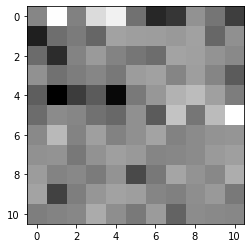

In [66]:
for i in range(50):
    conv1_1 = np.array(model.state_dict()['features.0.weight'])[i]
    img = conv1_1.reshape(11,11,504)
    img_r = img[:,:,0]*225/np.max(img[:,:,0])
    img_g = img[:,:,1]*225/np.max(img[:,:,1])
    img_b = img[:,:,2]*225/np.max(img[:,:,2])
    img_n = (img_r+img_g+img_b)/3
    #img = cv2.normalize(conv1_1.reshape(11,11,3),None,alpha=0,beta=225,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
    #img = img.astype(np.uint16)
    #print(img_n.shape)
    plt.imshow(img_n, cmap='gray')
    #plt.show()

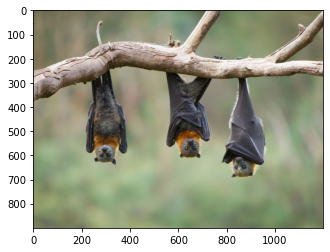

In [67]:
img = Image.open("data/test/bat/1fd53c0b98.jpg")
transform = data_transform["test"]
inputs = transform(img)
inputs = inputs.unsqueeze(0)
features = model.super_conv2d(model.filters,inputs)
plt.imshow(img)

torch.Size([1, 504, 176, 176])


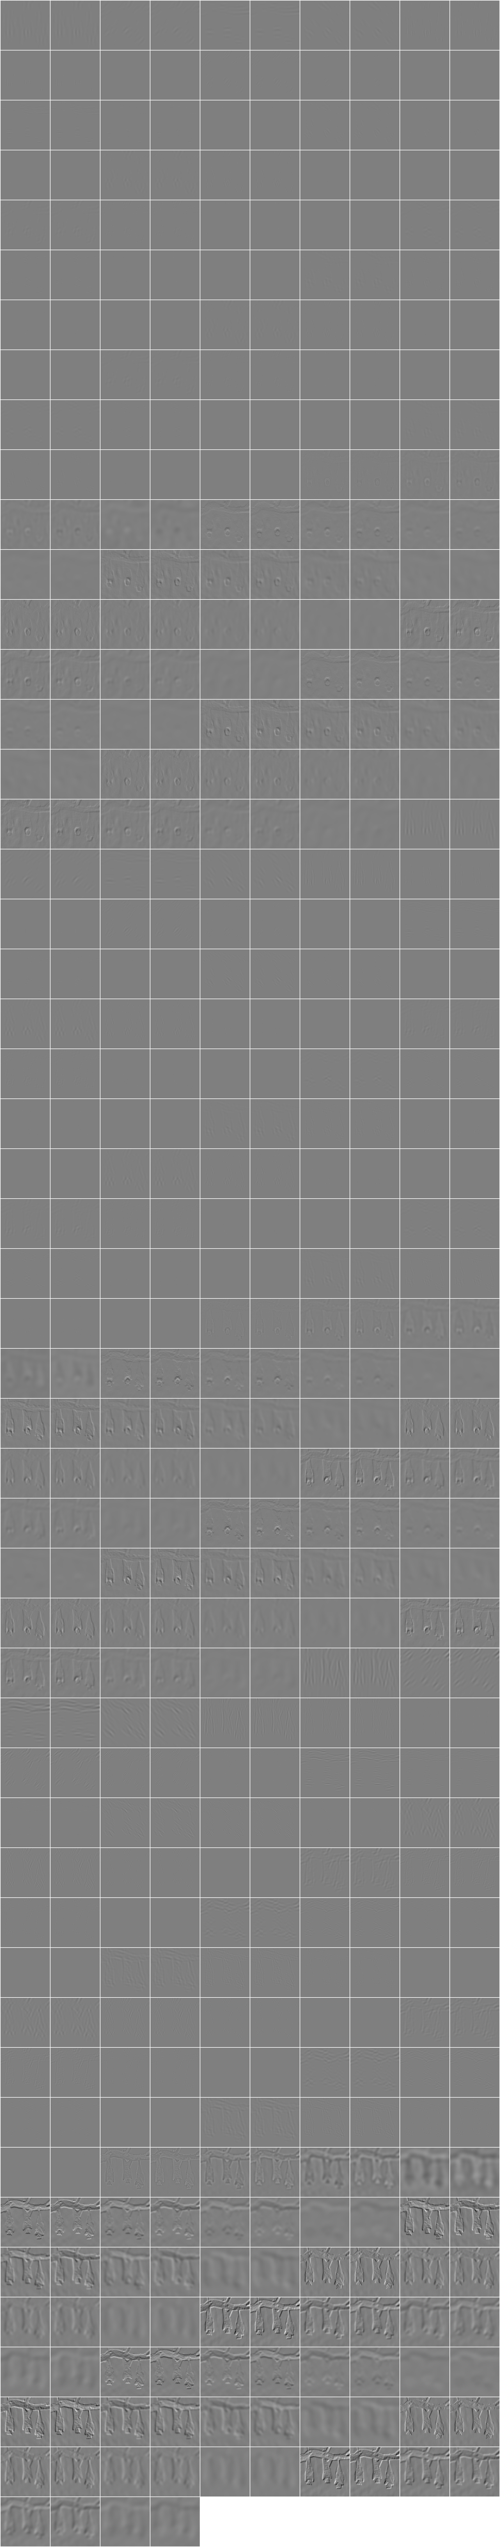

In [80]:
def feature_to_img(feature, nrow=10):
    # (N, H, W) -> (N, C, H, W)
    feature = feature.unsqueeze(1)
    # 画像化して、格子状に並べる
    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)
    # テンソル -> PIL Image
    img = transforms.functional.to_pil_image(img)
    # リサイズする。
    new_w = 500
    new_h = int(new_w * img.height / img.width)
    img = img.resize((new_w, new_h))

    return img

# (1, 504, H, W) のうち、16枚を可視化する。
print(features.shape)
img = feature_to_img(features[0][:])
img
#img = np.array(img)*255/np.max(np.array(img))
#plt.imshow(img)

torch.Size([1, 50, 43, 43])


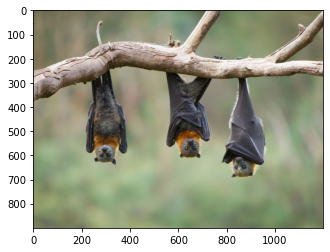

In [ ]:
def extract(target, inputs):
    feature = None

    def forward_hook(module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs)

    # コールバック関数を解除する。
    handle.remove()

    return features

img = Image.open("data/test/bat/1fd53c0b98.jpg")
transform = data_transform["test"]
inputs = transform(img)
inputs = inputs.unsqueeze(0)
# 抽出対象の層
target_module = model.features[1]  # (1): ReLU(inplace=True)

features = extract(target_module, inputs)
print(features.shape)
plt.imshow(img)

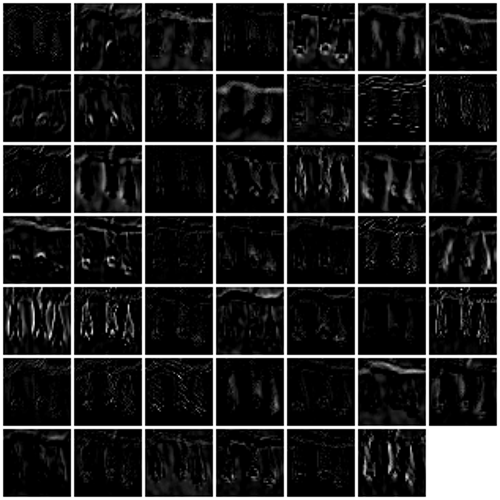

In [ ]:
def feature_to_img(feature, nrow=7):
    # (N, H, W) -> (N, C, H, W)
    feature = feature.unsqueeze(1)
    # 画像化して、格子状に並べる
    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)
    # テンソル -> PIL Image
    img = transforms.functional.to_pil_image(img)
    # リサイズする。
    new_w = 500
    new_h = int(new_w * img.height / img.width)
    img = img.resize((new_w, new_h))

    return img

# (1, 48, H, W) のうち、16枚を可視化する。
img = feature_to_img(features[0][:48])
img